# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [35]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Define method to split training and testing set

In [36]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]

### Load training set matrix

In [37]:
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_2.csv")
#labeled_matrix_training_set.columns.values[0] = "sampleId"
labeled_matrix_training_set = labeled_matrix_training_set.drop([labeled_matrix_training_set.columns[0]], axis = 1)
labels = list(range(0,5))


In [38]:
display(labeled_matrix_training_set.head(25))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,3,8,9,16,...,65,67,68,69,70,72,73,74,77,80
0,0.576312,0.715357,0.542345,0.770327,0.875863,0.436093,0.219046,0.093381,0.306327,-0.850429,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.531357,0.481223,0.552329,0.778592,0.802963,0.522301,0.332260,0.036914,0.233745,-0.951033,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.610292,0.748410,0.544124,0.673957,0.790218,0.395108,-0.059497,-0.056061,0.109607,-1.585542,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.677571,0.647227,0.562632,0.826889,0.835748,0.132817,0.529099,-0.040379,0.202314,-0.619159,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.694529,0.653745,0.651769,0.850960,0.813800,0.207992,0.265925,0.114829,0.234293,-0.879316,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
5,0.625919,0.546421,0.570326,0.723314,0.943585,0.099434,0.458407,0.783488,0.953391,-0.255512,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
6,0.619415,0.566868,0.548342,0.755120,0.841761,-0.960577,0.375832,-0.173501,0.123302,-0.562097,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
7,0.557171,0.577914,0.611604,0.895087,0.914860,-0.334538,0.416808,0.317006,0.459243,-1.689432,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
8,0.821077,0.698895,0.790806,NaN,NaN,-0.557269,0.301038,0.195996,0.364016,-0.690727,...,0.273373,0.029492,0.520527,-0.305875,0.234380,0.191366,0.088789,0.084635,-0.158168,-0.735119
9,NaN,NaN,NaN,NaN,NaN,0.472155,-0.079524,0.286920,0.462819,-0.417980,...,-0.244722,-0.314863,-0.243135,-0.440525,-0.080551,-0.213000,-0.366078,0.475861,0.663687,-0.376184


In [39]:
X = labeled_matrix_training_set.copy().drop(labeled_matrix_training_set.columns[labels], axis = 1)
y = labeled_matrix_training_set.copy()[labeled_matrix_training_set.columns[labels]]

In [40]:
display(X.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
0,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,0.313453,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,-0.052709,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.395108,-0.059497,-0.056061,0.109607,-1.585542,0.027163,-0.101243,-0.467931,0.036215,0.576793,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,0.240416,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.207992,0.265925,0.114829,0.234293,-0.879316,0.020543,0.028597,0.103498,0.247794,-0.674535,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957


In [41]:
display(y.head(15))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
0,0.576312,0.715357,0.542345,0.770327,0.875863
1,0.531357,0.481223,0.552329,0.778592,0.802963
2,0.610292,0.748410,0.544124,0.673957,0.790218
3,0.677571,0.647227,0.562632,0.826889,0.835748
4,0.694529,0.653745,0.651769,0.850960,0.813800
5,0.625919,0.546421,0.570326,0.723314,0.943585
6,0.619415,0.566868,0.548342,0.755120,0.841761
7,0.557171,0.577914,0.611604,0.895087,0.914860
8,0.821077,0.698895,0.790806,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [42]:
from sklearn.model_selection import train_test_split

all_X_TRAIN, all_X_TEST, all_Y_TRAIN, all_Y_TEST = train_test_split(X, y, test_size=0.20, random_state=42)
# TODO: train_test must be split on amount of NAs as well!

In [43]:
display(all_X_TRAIN.head())
display(all_Y_TRAIN.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
77,0.258306,0.145592,0.073569,0.233113,-0.872274,-0.003441,-0.876731,0.070761,0.209528,0.186785,...,0.088916,-0.010087,0.112097,-0.390746,0.209502,-0.472049,-0.530861,-0.583882,0.011045,-0.110352
42,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,0.606860,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
49,0.217305,0.165285,0.038625,0.236605,0.024422,-0.022316,-0.041843,0.095888,0.266678,0.251558,...,0.089018,-0.079240,0.197433,-0.045743,-0.000390,-0.026707,-0.038772,-0.088335,0.059579,-0.158037
11,0.364066,0.187369,0.040675,0.197984,0.107907,-0.060339,-0.000354,0.098138,0.251695,0.306306,...,0.098393,-0.037589,0.170131,-0.142253,-0.009636,0.018646,-0.016037,-0.105612,0.039937,-0.090132
30,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,0.713898,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
77,NaN,NaN,NaN,NaN,NaN
42,0.645679,0.630910,0.682710,0.942370,0.839335
49,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN
30,0.637520,0.652945,0.679371,0.822522,0.927028


In [44]:
display(all_X_TEST.head())
display(all_Y_TEST.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
78,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,0.208518,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
0,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,0.313453,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
68,0.268986,0.176367,0.051902,0.221065,0.050702,-0.019201,-0.085611,0.115679,0.299410,0.203980,...,0.059569,-0.029386,0.247056,0.015869,0.284147,0.036860,-0.002521,-0.109247,0.051980,-0.073419
22,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,-0.396658,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
12,0.274256,0.199654,0.056263,0.238684,0.015601,-0.004171,-0.055126,0.097506,0.261574,0.229485,...,0.092569,-0.022773,0.328441,0.031708,0.213800,0.027782,-0.000234,-0.079043,0.046129,-0.109735


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
78,0.777284,0.745540,0.701093,0.924357,0.866260
0,0.576312,0.715357,0.542345,0.770327,0.875863
68,NaN,NaN,NaN,NaN,NaN
22,0.915466,0.756732,0.877780,0.963176,1.000000
12,NaN,NaN,NaN,NaN,NaN


## Visualize ML Results

In [45]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [48]:
def retrieve_pipelines(model_name, ml_model):
    Ypipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     #('standardizer', StandardScaler()),
    ('normalizer', MinMaxScaler())
    ])

    XYpipeline = Pipeline([
            ('imputer', Imputer(axis=0,strategy="median")),
            #('standardizer', StandardScaler()),
            ('normalizer', MinMaxScaler()),
            #("pca", decomposition.PCA(n_components=10)),
            (model_name,  ml_model)
    ])
    
    return (Ypipeline, XYpipeline)

def imputer_inverse_transform(pre_data, post_data):
    na_indices = np.where(np.isnan(pre_data))[0]
    post_data[na_indices] = float('NaN')
    return post_data
    
def remove_NAs(X, y, label):
    label_y = y[[y.columns[label]]]
    na_indices = label_y[label_y.columns[0]].index[label_y[label_y.columns[0]].apply(np.isnan)]
    y_nonNA = label_y.copy().drop(na_indices)
    X_nonNA = X.copy().drop(na_indices)
    return X_nonNA, y_nonNA
    
def train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, this_y_train, this_y_test):
    this_y_train_tr = Ypipeline.fit_transform(this_y_train)
    XYpipeline.fit(X_TRAIN,this_y_train_tr)

    y_test_tr = Ypipeline.transform(this_y_test)
    y_prediction = XYpipeline.predict(X_TEST)

    y_prediction = Ypipeline.named_steps['normalizer'].inverse_transform(y_prediction)
    y_prediction = imputer_inverse_transform(this_y_test, y_prediction)

    y_test_np = this_y_test
    y_test_np = y_test_np[~np.isnan(y_test_np)]
    y_prediction = y_prediction[~np.isnan(y_prediction)]
    return (y_test_np, y_prediction, this_y_train_tr)


def simple_score(y_test_np, y_prediction):
    rmse = np.sqrt(mean_squared_error(y_test_np, y_prediction))
    r = scipy.stats.pearsonr(y_test_np, y_prediction)
    t = scipy.stats.spearmanr(y_test_np, y_prediction)
    return (rmse, r, t)
    
def visualize(y_test_np, y_prediction):
    plt.plot(y_test_np, y_prediction, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()
    
def display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST):
    TRAIN = pd.concat([Y_TRAIN, X_TRAIN], axis=1)
    TEST = pd.concat([Y_TEST, X_TEST], axis=1)
    pprint("TRAIN")
    display(TRAIN)
    pprint("TEST")
    display(TEST)

def cv_score(XYpipeline, X_TRAIN, this_y_train_tr):
    scores = cross_val_score(XYpipeline, X_TRAIN, this_y_train_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    scores = Ypipeline.named_steps['normalizer'].inverse_transform(scores)
    return scores


### Visualize ML results using Linear Regression

'TRAIN'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
37,0.719214,0.599909,-0.137347,-0.229387,-0.049305,-0.167514,0.257813,0.100341,0.337767,0.348361,...,-0.288384,-0.049142,0.132842,-0.302024,0.145497,-0.215205,-0.325561,0.525230,0.582973,-1.351511
2,0.610292,0.395108,-0.059497,-0.056061,0.109607,-1.585542,0.027163,-0.101243,-0.467931,0.036215,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
23,0.528983,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
78,0.777284,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
14,0.613860,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
73,0.695061,-0.726256,0.237195,0.159660,0.255252,-0.041759,-0.011539,-0.014875,0.078281,0.255237,...,0.084758,-0.078853,0.268396,0.093264,0.000046,-0.093076,-0.136615,-0.037779,0.101421,-0.228514
15,0.604702,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
56,0.649721,0.317511,0.218052,0.204815,0.352262,-0.891742,1.055896,0.616653,0.682774,0.886876,...,0.220462,0.036570,0.254057,-0.186027,0.387271,-0.879196,-0.852832,-0.856345,0.115005,-0.973859
31,0.744417,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193
6,0.619415,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023


'TEST'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
44,0.619454,0.372498,-0.029483,0.192683,0.300406,-0.712380,-0.349334,-0.299195,-0.259578,0.277840,...,-0.198787,-0.703658,-0.911131,-1.252536,-0.910134,-0.409008,-0.334662,-0.230351,-0.856709,-0.119734
24,0.622163,0.648641,0.514080,-0.038587,0.065573,-0.113948,-0.199212,0.827113,0.385578,0.553776,...,0.095438,-0.659941,-0.861221,-1.278328,-0.824294,-0.169197,-0.137028,-0.853852,0.589156,1.139465
84,0.591477,0.209831,-0.808317,-0.750588,0.358634,-0.961758,0.770711,0.360627,0.146476,0.012686,...,0.264957,-0.054121,0.497045,-0.356345,-0.119807,-0.012674,-0.037067,0.052281,0.799718,-0.999914
63,0.628506,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
26,0.741899,-0.637006,0.243437,0.001891,0.176538,-1.401450,0.414980,0.283914,0.450483,0.593558,...,0.062460,-0.629108,-1.803693,-0.729233,-0.346289,-0.516209,-0.528098,-0.650195,0.373628,-0.669397
61,0.790540,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
36,0.703385,0.332102,0.154244,0.096025,0.186280,0.011162,-0.223836,-0.097351,0.087742,0.209842,...,-0.390498,-0.105559,-0.093565,-0.226841,0.127339,-0.003120,-0.165546,0.239346,0.468985,-0.975393
71,0.774171,0.076031,-0.434927,0.042931,0.166515,-1.469969,-0.125940,0.254319,0.401064,0.809208,...,0.012569,0.290089,-0.760292,0.160126,0.467991,-0.078097,-0.083814,-0.127218,0.398344,-0.625993
42,0.645679,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
55,0.595509,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419


RMSE: 0.0889149348053
Pearson: (-0.28739227163188458, 0.3410481960904001)
Spearman: SpearmanrResult(correlation=-0.17582417582417581, pvalue=0.56557986195953447)


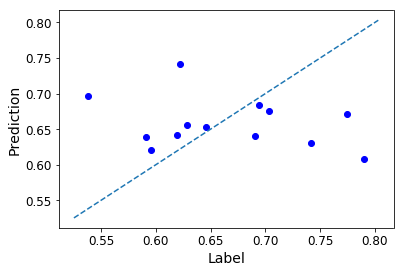

'TRAIN'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
40,0.575363,-0.664004,0.084070,0.011042,0.226630,-0.792907,0.028922,0.260095,0.329526,0.255372,...,0.163944,-0.013698,-0.110968,-0.121455,0.089076,-0.854566,-0.942120,-1.006756,0.121167,-0.563011
19,0.577722,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
15,0.564116,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
5,0.546421,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
33,0.631027,0.583449,0.266560,0.205795,-0.216464,-0.590275,0.124106,0.518899,0.562426,0.020219,...,-0.351980,0.013492,0.150896,0.045354,0.190954,-0.001475,-0.010121,-0.024547,0.226152,0.019438
10,0.705641,0.562714,0.374516,0.289336,0.481788,-0.653035,0.250990,-0.148644,0.347822,0.313760,...,-0.069589,0.040232,0.549443,-0.149689,0.024493,-0.715494,-0.751549,-0.807509,0.275388,-0.838196
1,0.481223,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
23,0.662895,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
32,0.697379,0.658000,0.190721,0.173310,-0.179189,-0.378291,-0.433262,0.544796,0.593400,0.302455,...,-0.325525,0.042444,0.468088,-0.063252,0.284201,-0.485585,-0.485492,-0.040121,0.599225,0.031946
80,0.565054,0.224842,0.200701,0.117990,0.299248,-0.852150,0.080079,1.009393,0.157660,0.761017,...,0.163620,-0.017176,0.319134,-0.209935,0.156199,-0.802015,-0.855750,-0.021106,0.143719,-0.213211


'TEST'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
24,0.560880,0.648641,0.514080,-0.038587,0.065573,-0.113948,-0.199212,0.827113,0.385578,0.553776,...,0.095438,-0.659941,-0.861221,-1.278328,-0.824294,-0.169197,-0.137028,-0.853852,0.589156,1.139465
56,0.588074,0.317511,0.218052,0.204815,0.352262,-0.891742,1.055896,0.616653,0.682774,0.886876,...,0.220462,0.036570,0.254057,-0.186027,0.387271,-0.879196,-0.852832,-0.856345,0.115005,-0.973859
7,0.577914,-0.334538,0.416808,0.317006,0.459243,-1.689432,0.299550,0.219070,0.350752,0.071599,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
35,0.555007,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
46,0.545283,0.187722,0.277828,0.175817,0.334200,0.105097,-0.833601,0.099912,0.138737,0.275474,...,0.248664,-0.466260,-0.902091,-1.300409,-0.881236,-0.031210,-0.035953,0.038061,0.168200,-1.098576
21,0.656106,0.318173,0.084660,0.073802,0.271221,-1.545981,0.045503,0.354825,0.461010,0.681002,...,0.040894,-0.491390,-1.120334,-0.753265,-0.574366,0.050446,-0.592556,-0.566400,1.005621,-0.600080
55,0.593731,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419
22,0.756732,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
71,0.722832,0.076031,-0.434927,0.042931,0.166515,-1.469969,-0.125940,0.254319,0.401064,0.809208,...,0.012569,0.290089,-0.760292,0.160126,0.467991,-0.078097,-0.083814,-0.127218,0.398344,-0.625993
25,0.592818,1.525981,0.189635,0.022854,0.147755,-0.939792,-0.075371,0.440905,0.588043,0.183787,...,0.049304,-0.121791,0.028781,-0.192062,0.027095,-0.694026,-0.729871,-0.834225,0.519114,-0.152975


RMSE: 0.0733951761307
Pearson: (0.35439312049973826, 0.23479883088319803)
Spearman: SpearmanrResult(correlation=0.2967032967032967, pvalue=0.32492158848597519)


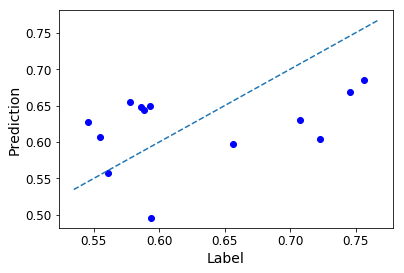

'TRAIN'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
29,0.679164,0.157990,-0.322231,-0.166649,-0.098250,-0.801414,1.560258,0.269189,0.464869,0.373487,...,-0.714632,0.024936,-0.043888,-0.124913,0.156270,-0.187006,-0.316239,0.307079,0.419559,-0.071497
19,0.602164,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
63,0.581497,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
30,0.679371,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384
34,0.579178,0.623985,0.226836,0.405109,-0.234539,-0.460864,-0.413416,0.496569,0.553532,0.317994,...,-0.350087,0.028416,0.324480,-0.361917,0.252115,-0.425491,-0.478697,-0.079960,0.444871,0.011813
35,0.577066,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
40,0.557068,-0.664004,0.084070,0.011042,0.226630,-0.792907,0.028922,0.260095,0.329526,0.255372,...,0.163944,-0.013698,-0.110968,-0.121455,0.089076,-0.854566,-0.942120,-1.006756,0.121167,-0.563011
14,0.549305,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
3,0.562632,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
72,0.602550,0.235951,0.397220,0.232373,0.380674,-1.681018,0.255941,-0.248559,-0.097720,0.148177,...,-0.091886,-0.147730,0.135907,-0.534161,-0.068636,-0.237379,-0.242543,-0.309670,0.750722,-0.912733


'TEST'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
22,0.877780,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
78,0.701093,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
24,0.560497,0.648641,0.514080,-0.038587,0.065573,-0.113948,-0.199212,0.827113,0.385578,0.553776,...,0.095438,-0.659941,-0.861221,-1.278328,-0.824294,-0.169197,-0.137028,-0.853852,0.589156,1.139465
10,0.711736,0.562714,0.374516,0.289336,0.481788,-0.653035,0.250990,-0.148644,0.347822,0.313760,...,-0.069589,0.040232,0.549443,-0.149689,0.024493,-0.715494,-0.751549,-0.807509,0.275388,-0.838196
6,0.548342,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
53,0.583725,-0.311980,0.188978,-0.328543,-0.023405,-0.415048,-0.435632,0.138366,0.179719,-0.193154,...,0.220613,-0.518884,-0.600909,-0.739336,-0.651961,-0.517926,-0.554708,-0.503599,0.850619,-0.633129
71,0.635591,0.076031,-0.434927,0.042931,0.166515,-1.469969,-0.125940,0.254319,0.401064,0.809208,...,0.012569,0.290089,-0.760292,0.160126,0.467991,-0.078097,-0.083814,-0.127218,0.398344,-0.625993
58,0.602269,0.389270,0.346501,-0.360803,-0.199066,-0.480322,0.799759,0.128940,0.234465,0.297446,...,-0.328492,0.054029,0.171760,-0.046912,0.136666,0.178629,0.022476,0.037120,0.192478,-0.545293
42,0.682710,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
56,0.647026,0.317511,0.218052,0.204815,0.352262,-0.891742,1.055896,0.616653,0.682774,0.886876,...,0.220462,0.036570,0.254057,-0.186027,0.387271,-0.879196,-0.852832,-0.856345,0.115005,-0.973859


RMSE: 0.0890571715354
Pearson: (0.37986671285008733, 0.20044775344594704)
Spearman: SpearmanrResult(correlation=0.40109890109890112, pvalue=0.17435746494503282)


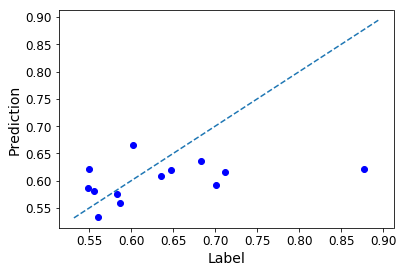

'TRAIN'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
57,0.643765,0.615093,-0.101981,-0.691337,-0.543106,-0.804280,0.205157,0.311615,0.523547,0.407874,...,0.100943,-0.535603,0.638599,0.021560,0.241659,-0.479582,-0.368535,0.100130,0.674387,-0.851801
63,0.696855,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
5,0.723314,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
3,0.826889,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
7,0.895087,-0.334538,0.416808,0.317006,0.459243,-1.689432,0.299550,0.219070,0.350752,0.071599,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
22,0.963176,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
60,0.762266,-0.707466,0.013022,0.275942,0.468375,-0.614229,0.163729,0.151776,0.267469,0.402895,...,0.237640,-0.023628,0.384223,-0.131184,0.219540,-0.136251,-0.156745,-0.208665,0.165950,0.520566
55,0.817725,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419
41,0.845183,0.028988,0.119004,-0.420839,0.223015,-0.275120,0.326761,0.366763,0.409552,0.091840,...,0.255966,-0.320901,-0.232270,-0.290437,0.083340,0.069838,0.058981,-0.122055,-0.541617,-0.692809
27,0.858990,0.398859,0.162388,-0.733963,0.390970,0.181827,0.103091,0.136074,0.738228,0.250418,...,0.806521,-0.765607,0.164400,-0.270181,-1.020937,0.064657,-0.018899,-0.128006,-0.627376,-0.981571


'TEST'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
14,0.831634,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
26,0.764149,-0.637006,0.243437,0.001891,0.176538,-1.401450,0.414980,0.283914,0.450483,0.593558,...,0.062460,-0.629108,-1.803693,-0.729233,-0.346289,-0.516209,-0.528098,-0.650195,0.373628,-0.669397
17,0.719198,-0.643871,0.275013,0.194772,0.369137,-0.666809,0.834148,0.196153,0.067816,0.419021,...,0.243152,0.131670,0.112095,-0.214004,0.104169,-0.332905,-0.295921,-0.312050,-0.154407,-0.003312
18,0.727964,0.064240,0.055867,-0.105052,0.058337,-1.607555,0.673806,0.317958,0.357247,0.075308,...,-0.101201,-0.236807,-0.103707,-0.266360,-0.182484,-0.181964,-0.226363,-0.266223,0.197921,0.045345
62,0.794304,-0.035858,0.327383,0.301367,0.456532,-1.144699,0.255829,0.329526,0.341944,-0.016995,...,0.364896,-0.321004,-0.755120,-0.179163,-0.128210,-0.314255,-0.297928,-0.393469,0.782964,-0.210686
19,0.742902,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
42,0.942370,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
39,0.692301,-0.033377,-0.709987,0.200426,0.318060,-0.816282,-0.297345,0.295657,0.384075,0.261302,...,0.570328,-0.005930,-1.285128,0.175297,0.317459,-0.375655,-0.356099,0.269924,0.541294,-0.411581
73,0.836726,-0.726256,0.237195,0.159660,0.255252,-0.041759,-0.011539,-0.014875,0.078281,0.255237,...,0.084758,-0.078853,0.268396,0.093264,0.000046,-0.093076,-0.136615,-0.037779,0.101421,-0.228514
75,0.615629,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496


RMSE: 0.0936653467448
Pearson: (0.45299285421909691, 0.13917722910803401)
Spearman: SpearmanrResult(correlation=0.20279720279720281, pvalue=0.52730235416610816)


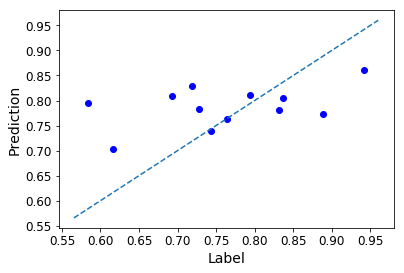

'TRAIN'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
45,0.950017,0.408618,0.239970,0.132204,0.329395,-0.872063,-0.023006,0.064081,0.159717,0.347745,...,0.184621,0.030339,0.395140,0.070150,0.343680,-0.832694,-0.887840,0.060472,0.128659,-0.819656
42,0.839335,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
10,0.812751,0.562714,0.374516,0.289336,0.481788,-0.653035,0.250990,-0.148644,0.347822,0.313760,...,-0.069589,0.040232,0.549443,-0.149689,0.024493,-0.715494,-0.751549,-0.807509,0.275388,-0.838196
63,0.703624,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
29,0.924399,0.157990,-0.322231,-0.166649,-0.098250,-0.801414,1.560258,0.269189,0.464869,0.373487,...,-0.714632,0.024936,-0.043888,-0.124913,0.156270,-0.187006,-0.316239,0.307079,0.419559,-0.071497
5,0.943585,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
73,0.893052,-0.726256,0.237195,0.159660,0.255252,-0.041759,-0.011539,-0.014875,0.078281,0.255237,...,0.084758,-0.078853,0.268396,0.093264,0.000046,-0.093076,-0.136615,-0.037779,0.101421,-0.228514
57,0.728443,0.615093,-0.101981,-0.691337,-0.543106,-0.804280,0.205157,0.311615,0.523547,0.407874,...,0.100943,-0.535603,0.638599,0.021560,0.241659,-0.479582,-0.368535,0.100130,0.674387,-0.851801
80,0.846689,0.224842,0.200701,0.117990,0.299248,-0.852150,0.080079,1.009393,0.157660,0.761017,...,0.163620,-0.017176,0.319134,-0.209935,0.156199,-0.802015,-0.855750,-0.021106,0.143719,-0.213211
59,0.791185,-0.724552,0.145695,0.129056,0.319179,-0.877704,0.016272,0.025682,0.158200,0.272115,...,0.134199,0.008095,0.221459,-0.333862,0.090087,-0.854928,-0.906549,0.466643,0.024067,-0.115916


'TEST'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
1,0.802963,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
36,0.755721,0.332102,0.154244,0.096025,0.186280,0.011162,-0.223836,-0.097351,0.087742,0.209842,...,-0.390498,-0.105559,-0.093565,-0.226841,0.127339,-0.003120,-0.165546,0.239346,0.468985,-0.975393
14,0.934615,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
17,0.800729,-0.643871,0.275013,0.194772,0.369137,-0.666809,0.834148,0.196153,0.067816,0.419021,...,0.243152,0.131670,0.112095,-0.214004,0.104169,-0.332905,-0.295921,-0.312050,-0.154407,-0.003312
23,0.654267,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
15,0.875436,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
61,0.838208,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
30,0.927028,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384
32,0.939280,0.658000,0.190721,0.173310,-0.179189,-0.378291,-0.433262,0.544796,0.593400,0.302455,...,-0.325525,0.042444,0.468088,-0.063252,0.284201,-0.485585,-0.485492,-0.040121,0.599225,0.031946
58,0.896108,0.389270,0.346501,-0.360803,-0.199066,-0.480322,0.799759,0.128940,0.234465,0.297446,...,-0.328492,0.054029,0.171760,-0.046912,0.136666,0.178629,0.022476,0.037120,0.192478,-0.545293


RMSE: 0.109586368771
Pearson: (-0.53094651377519486, 0.075703405927789666)
Spearman: SpearmanrResult(correlation=-0.52447552447552459, pvalue=0.080019375920274749)


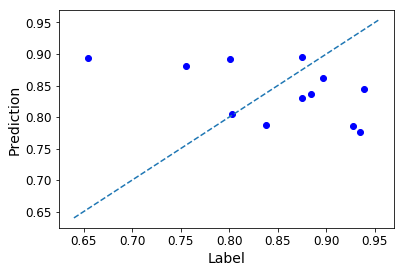

In [49]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Visualize ML results using Random Forest Regressor

'TRAIN'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
5,0.625919,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
34,0.585682,0.623985,0.226836,0.405109,-0.234539,-0.460864,-0.413416,0.496569,0.553532,0.317994,...,-0.350087,0.028416,0.324480,-0.361917,0.252115,-0.425491,-0.478697,-0.079960,0.444871,0.011813
55,0.595509,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419
54,0.710962,0.245887,0.207299,0.108435,0.253702,-0.781532,0.048739,0.000527,0.185921,0.295028,...,0.129210,0.042865,0.282655,-0.136132,0.245798,0.132670,0.069235,-0.034546,0.309249,-0.658802
18,0.591390,0.064240,0.055867,-0.105052,0.058337,-1.607555,0.673806,0.317958,0.357247,0.075308,...,-0.101201,-0.236807,-0.103707,-0.266360,-0.182484,-0.181964,-0.226363,-0.266223,0.197921,0.045345
23,0.528983,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
15,0.604702,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
58,0.721390,0.389270,0.346501,-0.360803,-0.199066,-0.480322,0.799759,0.128940,0.234465,0.297446,...,-0.328492,0.054029,0.171760,-0.046912,0.136666,0.178629,0.022476,0.037120,0.192478,-0.545293
19,0.680200,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
17,0.620575,-0.643871,0.275013,0.194772,0.369137,-0.666809,0.834148,0.196153,0.067816,0.419021,...,0.243152,0.131670,0.112095,-0.214004,0.104169,-0.332905,-0.295921,-0.312050,-0.154407,-0.003312


'TEST'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
76,0.594579,0.588470,0.220015,0.003538,0.165833,-1.024796,-0.038030,-0.777049,0.057068,0.206793,...,0.079509,-0.069078,-0.025949,-0.162296,0.136489,-0.955562,-0.977519,-1.052988,-0.076307,-0.113519
4,0.694529,0.207992,0.265925,0.114829,0.234293,-0.879316,0.020543,0.028597,0.103498,0.247794,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
38,0.659406,0.687273,0.220055,0.086717,0.239635,-0.789084,-0.005104,-0.029922,0.110578,0.258699,...,0.135586,-0.026951,-0.239543,-0.021152,-0.005297,-1.015847,-0.902437,-0.091258,0.626693,-0.073381
80,0.690240,0.224842,0.200701,0.117990,0.299248,-0.852150,0.080079,1.009393,0.157660,0.761017,...,0.163620,-0.017176,0.319134,-0.209935,0.156199,-0.802015,-0.855750,-0.021106,0.143719,-0.213211
75,0.547590,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496
59,0.574839,-0.724552,0.145695,0.129056,0.319179,-0.877704,0.016272,0.025682,0.158200,0.272115,...,0.134199,0.008095,0.221459,-0.333862,0.090087,-0.854928,-0.906549,0.466643,0.024067,-0.115916
61,0.790540,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
42,0.645679,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
14,0.613860,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
25,0.686644,1.525981,0.189635,0.022854,0.147755,-0.939792,-0.075371,0.440905,0.588043,0.183787,...,0.049304,-0.121791,0.028781,-0.192062,0.027095,-0.694026,-0.729871,-0.834225,0.519114,-0.152975


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0660135852201
Pearson: (0.20445871306552041, 0.50283149331768173)
Spearman: SpearmanrResult(correlation=0.18681318681318679, pvalue=0.5411235235098939)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


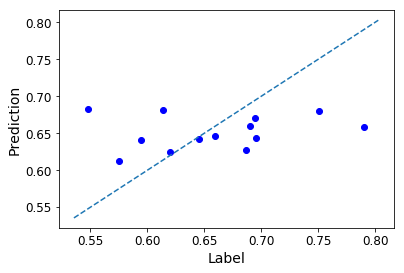

'TRAIN'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
19,0.577722,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
39,0.574002,-0.033377,-0.709987,0.200426,0.318060,-0.816282,-0.297345,0.295657,0.384075,0.261302,...,0.570328,-0.005930,-1.285128,0.175297,0.317459,-0.375655,-0.356099,0.269924,0.541294,-0.411581
42,0.630910,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
23,0.662895,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
6,0.566868,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
1,0.481223,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
5,0.546421,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
84,0.558231,0.209831,-0.808317,-0.750588,0.358634,-0.961758,0.770711,0.360627,0.146476,0.012686,...,0.264957,-0.054121,0.497045,-0.356345,-0.119807,-0.012674,-0.037067,0.052281,0.799718,-0.999914
31,0.667870,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193
2,0.748410,0.395108,-0.059497,-0.056061,0.109607,-1.585542,0.027163,-0.101243,-0.467931,0.036215,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374


'TEST'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
21,0.656106,0.318173,0.084660,0.073802,0.271221,-1.545981,0.045503,0.354825,0.461010,0.681002,...,0.040894,-0.491390,-1.120334,-0.753265,-0.574366,0.050446,-0.592556,-0.566400,1.005621,-0.600080
61,0.826007,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
22,0.756732,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
28,0.639675,0.314449,0.237437,0.159986,-0.544854,-0.716516,0.348593,0.090180,0.208602,0.892201,...,0.154605,0.058315,-0.956257,-0.140692,0.270730,0.124166,0.106010,0.046427,-0.785716,-0.377682
73,0.641439,-0.726256,0.237195,0.159660,0.255252,-0.041759,-0.011539,-0.014875,0.078281,0.255237,...,0.084758,-0.078853,0.268396,0.093264,0.000046,-0.093076,-0.136615,-0.037779,0.101421,-0.228514
75,0.589626,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496
36,0.716384,0.332102,0.154244,0.096025,0.186280,0.011162,-0.223836,-0.097351,0.087742,0.209842,...,-0.390498,-0.105559,-0.093565,-0.226841,0.127339,-0.003120,-0.165546,0.239346,0.468985,-0.975393
71,0.722832,0.076031,-0.434927,0.042931,0.166515,-1.469969,-0.125940,0.254319,0.401064,0.809208,...,0.012569,0.290089,-0.760292,0.160126,0.467991,-0.078097,-0.083814,-0.127218,0.398344,-0.625993
79,0.579235,0.125490,0.159371,0.149726,0.250616,0.066391,-0.772814,0.433117,0.553839,0.311573,...,0.170584,-0.035985,-1.343767,0.064796,0.030785,-0.105816,0.025369,-0.098780,-0.153367,-0.081876
56,0.588074,0.317511,0.218052,0.204815,0.352262,-0.891742,1.055896,0.616653,0.682774,0.886876,...,0.220462,0.036570,0.254057,-0.186027,0.387271,-0.879196,-0.852832,-0.856345,0.115005,-0.973859


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


RMSE: 0.0955950228387
Pearson: (-0.26476317509599134, 0.38201852253834179)
Spearman: SpearmanrResult(correlation=-0.25824175824175821, pvalue=0.39428401739736163)


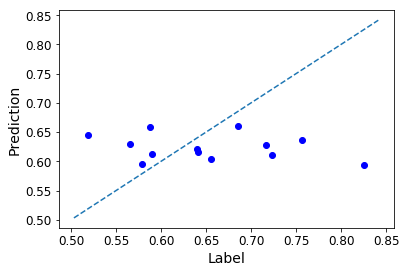

'TRAIN'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
53,0.583725,-0.311980,0.188978,-0.328543,-0.023405,-0.415048,-0.435632,0.138366,0.179719,-0.193154,...,0.220613,-0.518884,-0.600909,-0.739336,-0.651961,-0.517926,-0.554708,-0.503599,0.850619,-0.633129
39,0.610205,-0.033377,-0.709987,0.200426,0.318060,-0.816282,-0.297345,0.295657,0.384075,0.261302,...,0.570328,-0.005930,-1.285128,0.175297,0.317459,-0.375655,-0.356099,0.269924,0.541294,-0.411581
21,0.621525,0.318173,0.084660,0.073802,0.271221,-1.545981,0.045503,0.354825,0.461010,0.681002,...,0.040894,-0.491390,-1.120334,-0.753265,-0.574366,0.050446,-0.592556,-0.566400,1.005621,-0.600080
4,0.651769,0.207992,0.265925,0.114829,0.234293,-0.879316,0.020543,0.028597,0.103498,0.247794,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
42,0.682710,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
55,0.578875,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419
17,0.555850,-0.643871,0.275013,0.194772,0.369137,-0.666809,0.834148,0.196153,0.067816,0.419021,...,0.243152,0.131670,0.112095,-0.214004,0.104169,-0.332905,-0.295921,-0.312050,-0.154407,-0.003312
44,0.564607,0.372498,-0.029483,0.192683,0.300406,-0.712380,-0.349334,-0.299195,-0.259578,0.277840,...,-0.198787,-0.703658,-0.911131,-1.252536,-0.910134,-0.409008,-0.334662,-0.230351,-0.856709,-0.119734
10,0.711736,0.562714,0.374516,0.289336,0.481788,-0.653035,0.250990,-0.148644,0.347822,0.313760,...,-0.069589,0.040232,0.549443,-0.149689,0.024493,-0.715494,-0.751549,-0.807509,0.275388,-0.838196
19,0.602164,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554


'TEST'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
26,0.655725,-0.637006,0.243437,0.001891,0.176538,-1.401450,0.414980,0.283914,0.450483,0.593558,...,0.062460,-0.629108,-1.803693,-0.729233,-0.346289,-0.516209,-0.528098,-0.650195,0.373628,-0.669397
14,0.549305,0.311621,0.310739,-0.866207,-0.654559,0.180585,0.050780,0.022852,0.116973,0.285787,...,0.127948,-0.031667,0.262835,0.065896,0.028427,0.067152,-0.008213,-0.050196,-0.032852,-0.068656
27,0.668818,0.398859,0.162388,-0.733963,0.390970,0.181827,0.103091,0.136074,0.738228,0.250418,...,0.806521,-0.765607,0.164400,-0.270181,-1.020937,0.064657,-0.018899,-0.128006,-0.627376,-0.981571
30,0.679371,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384
31,0.563638,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193
84,0.530075,0.209831,-0.808317,-0.750588,0.358634,-0.961758,0.770711,0.360627,0.146476,0.012686,...,0.264957,-0.054121,0.497045,-0.356345,-0.119807,-0.012674,-0.037067,0.052281,0.799718,-0.999914
62,0.548900,-0.035858,0.327383,0.301367,0.456532,-1.144699,0.255829,0.329526,0.341944,-0.016995,...,0.364896,-0.321004,-0.755120,-0.179163,-0.128210,-0.314255,-0.297928,-0.393469,0.782964,-0.210686
56,0.647026,0.317511,0.218052,0.204815,0.352262,-0.891742,1.055896,0.616653,0.682774,0.886876,...,0.220462,0.036570,0.254057,-0.186027,0.387271,-0.879196,-0.852832,-0.856345,0.115005,-0.973859
23,0.491755,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
75,0.537030,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0890462819221
Pearson: (-0.22555899842808555, 0.45872357689057064)
Spearman: SpearmanrResult(correlation=-0.17582417582417581, pvalue=0.56557986195953447)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


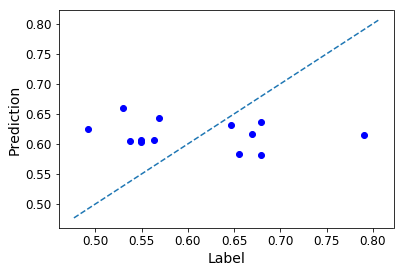

'TRAIN'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
19,0.742902,0.521106,0.090831,0.097462,0.268135,-1.608259,-0.138805,0.240739,0.366593,0.020663,...,-0.100418,-0.686984,-0.385417,-1.015519,-0.556133,0.044298,0.037689,-0.504741,0.433642,-0.516554
57,0.643765,0.615093,-0.101981,-0.691337,-0.543106,-0.804280,0.205157,0.311615,0.523547,0.407874,...,0.100943,-0.535603,0.638599,0.021560,0.241659,-0.479582,-0.368535,0.100130,0.674387,-0.851801
79,0.739124,0.125490,0.159371,0.149726,0.250616,0.066391,-0.772814,0.433117,0.553839,0.311573,...,0.170584,-0.035985,-1.343767,0.064796,0.030785,-0.105816,0.025369,-0.098780,-0.153367,-0.081876
71,0.778938,0.076031,-0.434927,0.042931,0.166515,-1.469969,-0.125940,0.254319,0.401064,0.809208,...,0.012569,0.290089,-0.760292,0.160126,0.467991,-0.078097,-0.083814,-0.127218,0.398344,-0.625993
63,0.696855,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
5,0.723314,0.099434,0.458407,0.783488,0.953391,-0.255512,-0.266247,-0.296886,-0.167956,-0.056009,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
24,0.853731,0.648641,0.514080,-0.038587,0.065573,-0.113948,-0.199212,0.827113,0.385578,0.553776,...,0.095438,-0.659941,-0.861221,-1.278328,-0.824294,-0.169197,-0.137028,-0.853852,0.589156,1.139465
75,0.615629,-1.070249,0.306451,-0.476875,-0.274606,-1.329115,0.340248,-0.025836,0.117655,1.255420,...,0.536290,-0.532914,-0.076870,-0.844192,-0.461503,-1.426220,-0.132299,-0.646015,0.054185,-0.564496
15,0.724743,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
25,0.776366,1.525981,0.189635,0.022854,0.147755,-0.939792,-0.075371,0.440905,0.588043,0.183787,...,0.049304,-0.121791,0.028781,-0.192062,0.027095,-0.694026,-0.729871,-0.834225,0.519114,-0.152975


'TEST'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
33,0.641945,0.583449,0.266560,0.205795,-0.216464,-0.590275,0.124106,0.518899,0.562426,0.020219,...,-0.351980,0.013492,0.150896,0.045354,0.190954,-0.001475,-0.010121,-0.024547,0.226152,0.019438
61,0.875244,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
28,0.886014,0.314449,0.237437,0.159986,-0.544854,-0.716516,0.348593,0.090180,0.208602,0.892201,...,0.154605,0.058315,-0.956257,-0.140692,0.270730,0.124166,0.106010,0.046427,-0.785716,-0.377682
6,0.755120,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
55,0.817725,-0.694693,1.673895,-0.851859,0.276237,-0.734077,0.386585,0.626017,0.683642,0.268465,...,0.136656,-0.026346,-0.149542,-0.303511,0.187407,0.020091,0.030462,-0.063313,0.098395,-0.994419
80,0.848018,0.224842,0.200701,0.117990,0.299248,-0.852150,0.080079,1.009393,0.157660,0.761017,...,0.163620,-0.017176,0.319134,-0.209935,0.156199,-0.802015,-0.855750,-0.021106,0.143719,-0.213211
29,0.888039,0.157990,-0.322231,-0.166649,-0.098250,-0.801414,1.560258,0.269189,0.464869,0.373487,...,-0.714632,0.024936,-0.043888,-0.124913,0.156270,-0.187006,-0.316239,0.307079,0.419559,-0.071497
62,0.794304,-0.035858,0.327383,0.301367,0.456532,-1.144699,0.255829,0.329526,0.341944,-0.016995,...,0.364896,-0.321004,-0.755120,-0.179163,-0.128210,-0.314255,-0.297928,-0.393469,0.782964,-0.210686
23,0.735328,0.508660,0.389423,0.353788,0.494711,-1.435452,0.373325,0.008868,-0.007638,0.182468,...,-0.546441,0.035851,0.286341,-0.237297,0.192224,-0.660539,-0.676271,-0.125205,-0.040901,-0.793571
73,0.836726,-0.726256,0.237195,0.159660,0.255252,-0.041759,-0.011539,-0.014875,0.078281,0.255237,...,0.084758,-0.078853,0.268396,0.093264,0.000046,-0.093076,-0.136615,-0.037779,0.101421,-0.228514


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


RMSE: 0.119914486717
Pearson: (-0.63395012191774935, 0.026849236261496073)
Spearman: SpearmanrResult(correlation=-0.39160839160839161, pvalue=0.2080634636953532)


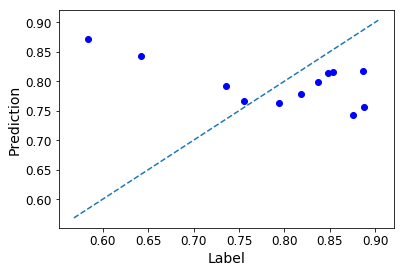

'TRAIN'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
7,0.914860,-0.334538,0.416808,0.317006,0.459243,-1.689432,0.299550,0.219070,0.350752,0.071599,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
25,0.782240,1.525981,0.189635,0.022854,0.147755,-0.939792,-0.075371,0.440905,0.588043,0.183787,...,0.049304,-0.121791,0.028781,-0.192062,0.027095,-0.694026,-0.729871,-0.834225,0.519114,-0.152975
0,0.875863,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
38,0.780229,0.687273,0.220055,0.086717,0.239635,-0.789084,-0.005104,-0.029922,0.110578,0.258699,...,0.135586,-0.026951,-0.239543,-0.021152,-0.005297,-1.015847,-0.902437,-0.091258,0.626693,-0.073381
46,0.746754,0.187722,0.277828,0.175817,0.334200,0.105097,-0.833601,0.099912,0.138737,0.275474,...,0.248664,-0.466260,-0.902091,-1.300409,-0.881236,-0.031210,-0.035953,0.038061,0.168200,-1.098576
6,0.841761,-0.960577,0.375832,-0.173501,0.123302,-0.562097,-0.154453,-0.010504,0.190095,0.467486,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
15,0.875436,0.301096,0.170113,0.058487,0.215570,-0.806670,-0.020257,0.010343,0.085553,0.265606,...,0.104056,-0.097079,0.154954,-0.224197,-0.007403,-0.013478,-0.064091,-0.075396,0.419206,-0.989799
63,0.703624,-1.106883,0.304349,-0.032793,0.352499,-0.668086,0.173285,0.069396,0.239072,0.361896,...,0.238260,0.091738,-0.305479,-0.132690,0.186750,0.189021,0.066422,0.040599,0.517277,-0.843237
30,0.927028,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384
16,0.911643,-0.578688,0.286697,0.407330,0.526137,-0.919606,0.056907,0.127930,-0.067973,-0.669326,...,0.157793,0.016885,0.455764,-0.103655,0.289889,-0.861582,-0.862945,-0.803094,0.058471,-0.997249


'TEST'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
61,0.838208,0.457804,-0.564891,0.228308,0.303327,-0.691149,-0.535123,0.101311,0.207659,0.584738,...,0.392570,-0.779931,-0.824033,-0.749541,-0.737905,0.170624,0.127514,0.026419,0.217194,-0.828724
59,0.791185,-0.724552,0.145695,0.129056,0.319179,-0.877704,0.016272,0.025682,0.158200,0.272115,...,0.134199,0.008095,0.221459,-0.333862,0.090087,-0.854928,-0.906549,0.466643,0.024067,-0.115916
35,0.797361,0.471059,0.037412,-0.048361,0.132522,-0.640478,-0.075271,0.584531,0.683658,0.118624,...,-0.036340,-0.163381,0.118815,-0.171836,0.019516,-0.605981,-0.696899,0.487024,0.689926,-0.768274
33,0.924407,0.583449,0.266560,0.205795,-0.216464,-0.590275,0.124106,0.518899,0.562426,0.020219,...,-0.351980,0.013492,0.150896,0.045354,0.190954,-0.001475,-0.010121,-0.024547,0.226152,0.019438
78,0.866260,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
58,0.896108,0.389270,0.346501,-0.360803,-0.199066,-0.480322,0.799759,0.128940,0.234465,0.297446,...,-0.328492,0.054029,0.171760,-0.046912,0.136666,0.178629,0.022476,0.037120,0.192478,-0.545293
80,0.846689,0.224842,0.200701,0.117990,0.299248,-0.852150,0.080079,1.009393,0.157660,0.761017,...,0.163620,-0.017176,0.319134,-0.209935,0.156199,-0.802015,-0.855750,-0.021106,0.143719,-0.213211
71,0.919561,0.076031,-0.434927,0.042931,0.166515,-1.469969,-0.125940,0.254319,0.401064,0.809208,...,0.012569,0.290089,-0.760292,0.160126,0.467991,-0.078097,-0.083814,-0.127218,0.398344,-0.625993
40,0.862368,-0.664004,0.084070,0.011042,0.226630,-0.792907,0.028922,0.260095,0.329526,0.255372,...,0.163944,-0.013698,-0.110968,-0.121455,0.089076,-0.854566,-0.942120,-1.006756,0.121167,-0.563011
31,0.874489,0.210411,0.332066,0.213128,-0.180401,-0.323674,0.153863,0.562423,0.611391,0.350031,...,-0.284426,0.053507,0.371654,0.199069,0.183966,0.172875,-0.055108,-0.069684,0.668060,-0.000193


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


RMSE: 0.051287037077
Pearson: (0.57464048265050838, 0.05066185666995579)
Spearman: SpearmanrResult(correlation=0.30769230769230771, pvalue=0.3305892594121097)


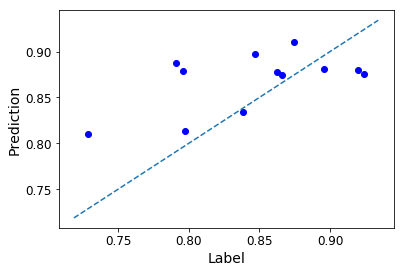

In [50]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Bootstrap Regression Model

RMSE: 0.0875057550068
Pearson: (0.21644456051194533, 0.019081945284415026)
Spearman: SpearmanrResult(correlation=0.18740386117681723, pvalue=0.043044135462303151)


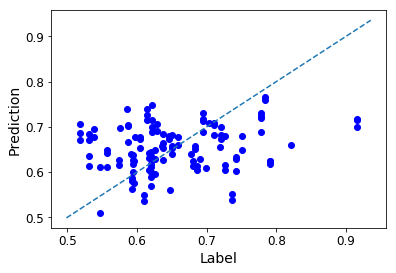

RMSE: 0.0752325609802
Pearson: (0.19342958431858642, 0.036656066413511892)
Spearman: SpearmanrResult(correlation=0.2142569472221876, pvalue=0.020358890194826337)


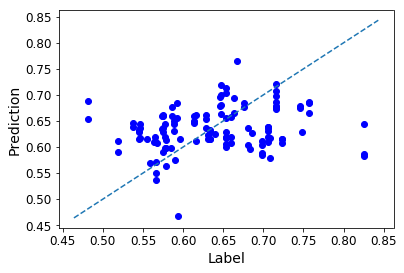

RMSE: 0.0835545088814
Pearson: (0.20945078886275573, 0.023424889112328685)
Spearman: SpearmanrResult(correlation=0.21783944930559554, pvalue=0.018304315498368411)


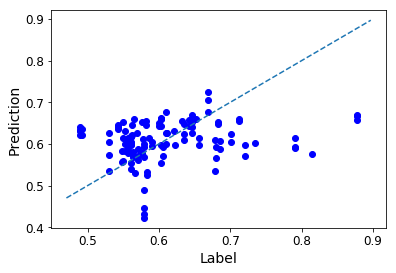

RMSE: 0.0959818210216
Pearson: (0.10721733569953708, 0.26939495441981248)
Spearman: SpearmanrResult(correlation=0.10678679850869123, pvalue=0.27133370307167853)


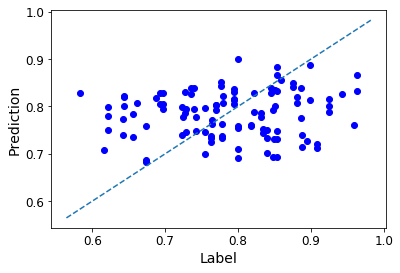

RMSE: 0.0790533592173
Pearson: (-0.21269250436136145, 0.02710537779567462)
Spearman: SpearmanrResult(correlation=-0.20379253181529614, pvalue=0.03438868686434244)


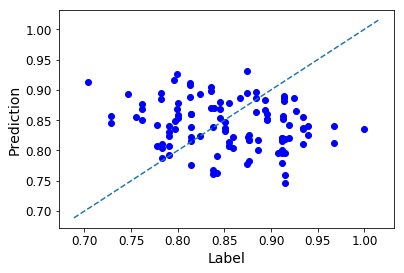

In [51]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)

        Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.80))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)


### Bootstrap Random Forest Model

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0661192614118
Pearson: (0.15123368430051648, 0.37861129083178591)
Spearman: SpearmanrResult(correlation=0.12471019249374674, pvalue=0.46864208758921633)


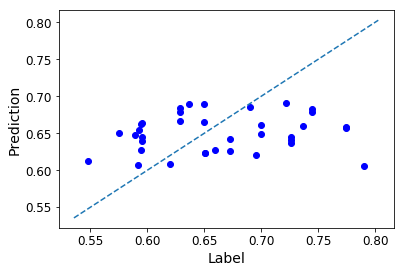

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0677158564692
Pearson: (0.15410425933830429, 0.36952100460359405)
Spearman: SpearmanrResult(correlation=0.25307844687955783, pvalue=0.13642241509817191)


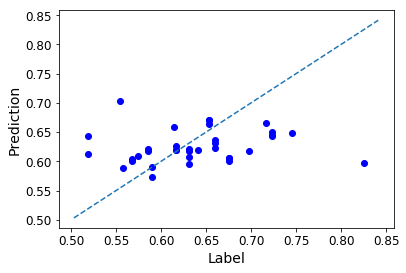

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0885138630394
Pearson: (-0.37538981257040815, 0.024066230290709811)
Spearman: SpearmanrResult(correlation=-0.32469747530748239, pvalue=0.053341735283923851)


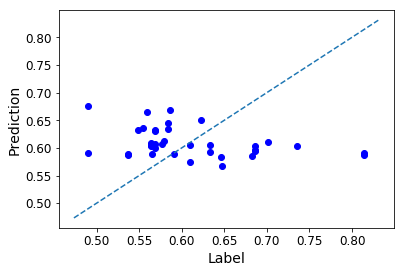

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.114237384128
Pearson: (-0.14886373459682761, 0.38621436279490418)
Spearman: SpearmanrResult(correlation=-0.13262942784261389, pvalue=0.44064284159298905)


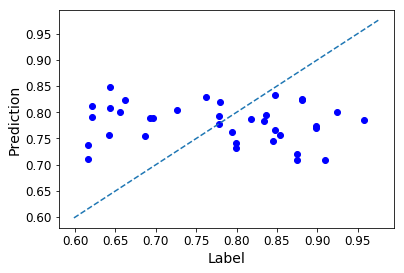

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0735247300967
Pearson: (0.11525362299155507, 0.50327049090538434)
Spearman: SpearmanrResult(correlation=0.11931460155024985, pvalue=0.48824375104050544)


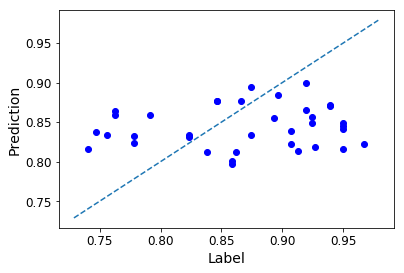

In [249]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)
